In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. CSV 데이터 로드
df = pd.read_csv("./turret_info.csv")  # 파일 경로를 실제 파일명으로 바꿔주세요

# 1. 입력 / 출력 분리
features = df[['x_pos', 'y_pos', 'z_pos', 'x_target', 'y_target', 'z_target']].values.astype('float32')
angles_deg = df[['x_angle', 'y_angle']].values.astype('float32')
angles = np.radians(angles_deg)

# 2. 출력 각도를 sin/cos로 변환
def angles_to_sincos(angles):
    yaw = angles[:, 0]   # x_angle
    pitch = angles[:, 1] # y_angle
    sin_yaw = np.sin(yaw)
    cos_yaw = np.cos(yaw)
    sin_pitch = np.sin(pitch)
    cos_pitch = np.cos(pitch)
    return np.stack([sin_yaw, cos_yaw, sin_pitch, cos_pitch], axis=1)

targets = angles_to_sincos(angles)  # shape: (N, 4)

# 3. 입력 스케일링
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 4. train/val 분할
X_train, X_val, y_train, y_val = train_test_split(features_scaled, targets, test_size=0.2, random_state=42)

# 5. PyTorch Dataset 구성
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

class MLP_Yaw(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 128),  # 입력 (6) -> 128 뉴런
            nn.ReLU(),
            nn.Linear(128, 64), # 128 뉴런 -> 64 뉴런
            nn.ReLU(),
            nn.Linear(64, 2)    # 64 뉴런 -> 출력 (2)
        )

    def forward(self, x):
        return self.net(x)


class MLP_Pitch(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # sin(pitch), cos(pitch)
        )

    def forward(self, x):
        return self.net(x)

def sincos_to_angles(sincos_preds):
    sin_yaw = sincos_preds[:, 0]
    cos_yaw = sincos_preds[:, 1]
    sin_pitch = sincos_preds[:, 2]
    cos_pitch = sincos_preds[:, 3]
    yaw = np.arctan2(sin_yaw, cos_yaw)
    pitch = np.arctan2(sin_pitch, cos_pitch)
    return np.stack([yaw, pitch], axis=1)

# 7. 학습 루프
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_yaw = MLP_Yaw().to(device)
model_pitch = MLP_Pitch().to(device)

criterion = nn.MSELoss()
optimizer_yaw = optim.Adam(model_yaw.parameters(), lr=1e-3, weight_decay=1e-5)
optimizer_pitch = optim.Adam(model_pitch.parameters(), lr=1e-3)

# Early Stopping 설정
best_val_loss = float('inf')
patience = 30
min_delta = 1e-4
counter = 0
best_model_state = None
n_epochs = 3000  # 최대 에폭 수

# ✅ 정규화 손실 항 추가 함수
def normalization_loss(pred):
    # 입력 'pred'는 (sin_angle, cos_angle) 형태의 2개 요소를 가진 텐서여야 합니다.
    # 따라서 정규화는 pred[:, 0] (sin)와 pred[:, 1] (cos)에 대해서만 수행합니다.
    norm = pred[:, 0]**2 + pred[:, 1]**2
    loss = ((norm - 1) ** 2).mean()
    return loss

lambda_norm = 0.1  # 정규화 손실 가중치

for epoch in range(n_epochs):
    model_yaw.train()
    model_pitch.train()
    train_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        yaw_target = yb[:, :2]
        pitch_target = yb[:, 2:]

        # --- Yaw 예측 ---
        pred_yaw = model_yaw(xb)
        loss_yaw = criterion(pred_yaw, yaw_target)
        # ✅ 여기에 수정된 normalization_loss 적용
        loss_yaw += lambda_norm * normalization_loss(pred_yaw)
        optimizer_yaw.zero_grad()
        loss_yaw.backward()
        optimizer_yaw.step()

        # --- Pitch 예측 ---
        pred_pitch = model_pitch(xb)
        loss_pitch = criterion(pred_pitch, pitch_target)
        # ✅ 여기에 수정된 normalization_loss 적용
        loss_pitch += lambda_norm * normalization_loss(pred_pitch)
        optimizer_pitch.zero_grad()
        loss_pitch.backward()
        optimizer_pitch.step()

        train_loss += (loss_yaw.item() + loss_pitch.item())

    train_loss /= len(train_loader)

    # 검증 + 각도 평가
    model_yaw.eval()
    model_pitch.eval()
    val_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            yaw_target = yb[:, :2]
            pitch_target = yb[:, 2:]

            pred_yaw = model_yaw(xb)
            pred_pitch = model_pitch(xb)

            loss_yaw_val = criterion(pred_yaw, yaw_target)
            loss_pitch_val = criterion(pred_pitch, pitch_target)
            # 검증 손실에도 정규화 손실을 포함하려면 여기에 추가할 수 있습니다.
            # val_loss += (loss_yaw_val.item() + lambda_norm * normalization_loss(pred_yaw).item() +
            #              loss_pitch_val.item() + lambda_norm * normalization_loss(pred_pitch).item())
            val_loss += (loss_yaw_val.item() + loss_pitch_val.item()) # 현재는 MSE만 합산

            pred = torch.cat([pred_yaw, pred_pitch], dim=1)
            all_preds.append(pred.cpu().numpy())
            all_targets.append(yb.cpu().numpy())

    val_loss /= len(val_loader)

    # 예측 복원 및 각도 오차 계산
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    pred_angles = sincos_to_angles(all_preds)
    target_angles = sincos_to_angles(all_targets)

    angle_error = np.abs(pred_angles - target_angles)
    angle_error_deg = np.degrees(angle_error)
    mean_error = angle_error_deg.mean(axis=0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f} | "
          f"Mean angle error: yaw={mean_error[0]:.2f}°, pitch={mean_error[1]:.2f}°")


    # Early stopping
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# 가장 성능이 좋았던 모델 로드
if best_model_state is not None:
    model.load_state_dict(best_model_state)

Epoch 1, Train Loss: 0.544744, Val Loss: 0.318898 | Mean angle error: yaw=61.61°, pitch=3.59°
Epoch 2, Train Loss: 0.345205, Val Loss: 0.256307 | Mean angle error: yaw=47.91°, pitch=2.63°
Epoch 3, Train Loss: 0.447631, Val Loss: 0.277269 | Mean angle error: yaw=55.64°, pitch=2.32°
Epoch 4, Train Loss: 0.307992, Val Loss: 0.228492 | Mean angle error: yaw=42.28°, pitch=2.13°
Epoch 5, Train Loss: 0.262678, Val Loss: 0.209342 | Mean angle error: yaw=41.08°, pitch=1.94°
Epoch 6, Train Loss: 0.244031, Val Loss: 0.194759 | Mean angle error: yaw=37.57°, pitch=1.80°
Epoch 7, Train Loss: 0.225033, Val Loss: 0.177914 | Mean angle error: yaw=36.06°, pitch=1.72°
Epoch 8, Train Loss: 0.205816, Val Loss: 0.159769 | Mean angle error: yaw=36.36°, pitch=1.60°
Epoch 9, Train Loss: 0.182374, Val Loss: 0.146504 | Mean angle error: yaw=37.42°, pitch=1.60°
Epoch 10, Train Loss: 0.160132, Val Loss: 0.136874 | Mean angle error: yaw=35.71°, pitch=1.54°
Epoch 11, Train Loss: 0.143300, Val Loss: 0.127130 | Mean a

In [32]:
!pip install seaborn matplotlib numpy


--- 예측 결과 시각화 ---


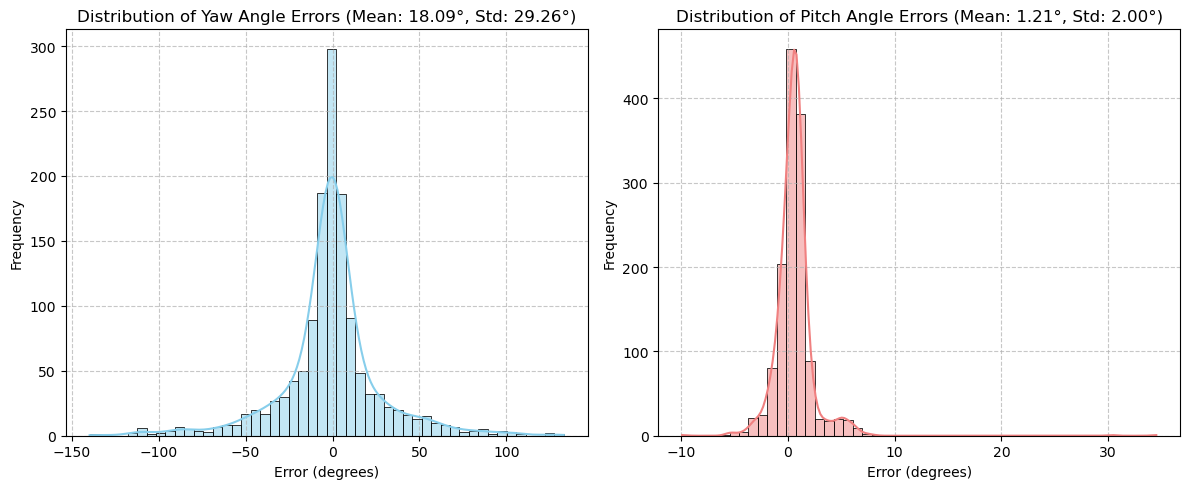

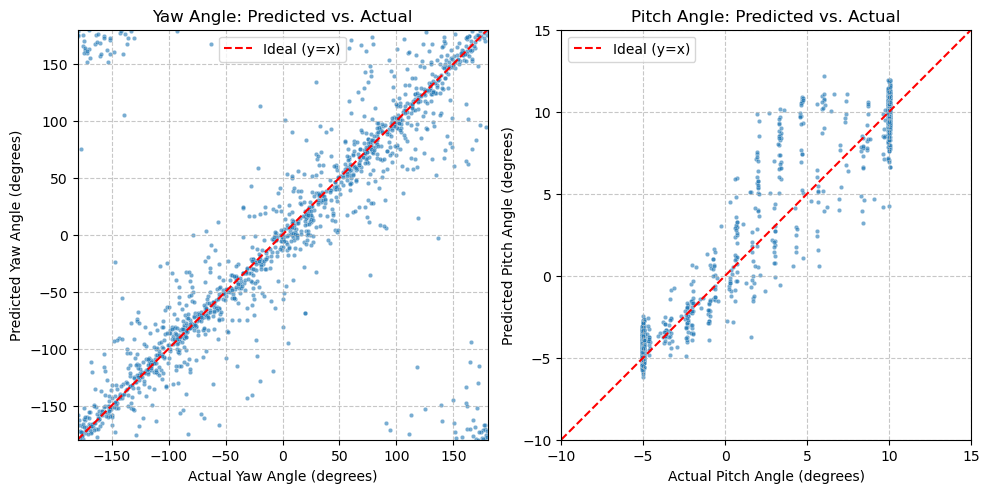


평균 요 각도 오차: 18.09°
평균 피치 각도 오차: 1.21°


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns # 더 예쁜 그래프를 위해 seaborn을 사용합니다.
import numpy as np # 넘파이 import 추가

# 이미 학습된 model_yaw, model_pitch, val_loader, sincos_to_angles 함수를 사용합니다.
# device도 이미 정의되어 있어야 합니다. (cuda 또는 cpu)

# 8. 예측값과 실제값 시각화

# 모델을 평가 모드로 전환
model_yaw.eval()
model_pitch.eval()

all_preds_sincos = []
all_targets_sincos = []
all_features_scaled = [] # 입력 특성도 필요할 수 있으니 수집

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)

        pred_yaw_sincos = model_yaw(xb)
        pred_pitch_sincos = model_pitch(xb)

        # 예측된 sin/cos 값을 합쳐서 나중에 각도로 변환할 준비
        pred_sincos = torch.cat([pred_yaw_sincos, pred_pitch_sincos], dim=1)

        all_preds_sincos.append(pred_sincos.cpu().numpy())
        all_targets_sincos.append(yb.cpu().numpy())
        all_features_scaled.append(xb.cpu().numpy())


# 수집된 데이터 concatenate
all_preds_sincos = np.concatenate(all_preds_sincos, axis=0)
all_targets_sincos = np.concatenate(all_targets_sincos, axis=0)
all_features_scaled = np.concatenate(all_features_scaled, axis=0)

# sin/cos 값을 다시 각도 (라디안)로 변환
predicted_angles_rad = sincos_to_angles(all_preds_sincos)
actual_angles_rad = sincos_to_angles(all_targets_sincos)

# 각도를 도로 변환 (시각화 편의상)
predicted_angles_deg = np.degrees(predicted_angles_rad)
actual_angles_deg = np.degrees(actual_angles_rad)

# 오차 계산 (절대 오차)
# 요(yaw) 오차: predicted_angles_deg[:, 0] - actual_angles_deg[:, 0]
# 피치(pitch) 오차: predicted_angles_deg[:, 1] - actual_angles_deg[:, 1]
yaw_errors = predicted_angles_deg[:, 0] - actual_angles_deg[:, 0]
pitch_errors = predicted_angles_deg[:, 1] - actual_angles_deg[:, 1]

# 각도 오차를 -180 ~ 180 범위로 정규화 (특히 요 각도에서 중요)
# 예를 들어 실제 170도, 예측 -170도면 오차는 340도가 아니라 20도로 보는 것이 맞음
yaw_errors = (yaw_errors + 180) % 360 - 180
pitch_errors = (pitch_errors + 180) % 360 - 180


# --- 시각화 ---
print("\n--- 예측 결과 시각화 ---")

# 1. 요(Yaw) 각도 오차 분포 히스토그램
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(yaw_errors, bins=50, kde=True, color='skyblue')
plt.title(f'Distribution of Yaw Angle Errors (Mean: {np.mean(np.abs(yaw_errors)):.2f}°, Std: {np.std(yaw_errors):.2f}°)')
plt.xlabel('Error (degrees)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)

# 2. 피치(Pitch) 각도 오차 분포 히스토그램
plt.subplot(1, 2, 2)
sns.histplot(pitch_errors, bins=50, kde=True, color='lightcoral')
plt.title(f'Distribution of Pitch Angle Errors (Mean: {np.mean(np.abs(pitch_errors)):.2f}°, Std: {np.std(pitch_errors):.2f}°)')
plt.xlabel('Error (degrees)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. 요(Yaw) 각도: 예측 vs 실제 값 산점도
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=actual_angles_deg[:, 0], y=predicted_angles_deg[:, 0], alpha=0.6, s=10)
plt.plot([-180, 180], [-180, 180], color='red', linestyle='--', label='Ideal (y=x)') # 이상적인 예측선
plt.title('Yaw Angle: Predicted vs. Actual')
plt.xlabel('Actual Yaw Angle (degrees)')
plt.ylabel('Predicted Yaw Angle (degrees)')
plt.xlim(-180, 180)
plt.ylim(-180, 180)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box') # x, y 축 비율 동일하게

# 4. 피치(Pitch) 각도: 예측 vs 실제 값 산점도
plt.subplot(1, 2, 2)
sns.scatterplot(x=actual_angles_deg[:, 1], y=predicted_angles_deg[:, 1], alpha=0.6, s=10)
plt.plot([-10, 15], [-10, 15], color='red', linestyle='--', label='Ideal (y=x)') # 피치 범위에 맞게 조정
plt.title('Pitch Angle: Predicted vs. Actual')
plt.xlabel('Actual Pitch Angle (degrees)')
plt.ylabel('Predicted Pitch Angle (degrees)')
# 피치 각도 범위는 보통 -90에서 90도 사이이므로 xlim/ylim을 적절히 조정
plt.xlim(-10, 15)
plt.ylim(-10, 15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box') # x, y 축 비율 동일하게
plt.tight_layout()
plt.show()

# 5. 요 각도 오차와 입력 특성 관계 (선택적)
# 특정 입력 특성이 요 각도 오차와 관련이 있는지 확인하기 위해
# 예를 들어, x_pos와 요 각도 오차의 관계를 볼 수 있습니다.
# all_features_scaled를 역변환하여 원래 값으로 되돌리는 것이 더 의미 있을 수 있습니다.
# if 'scaler' in globals(): # scaler가 정의되어 있는지 확인
#     original_features = scaler.inverse_transform(all_features_scaled)
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     sns.scatterplot(x=original_features[:, 0], y=yaw_errors, alpha=0.6, s=10)
#     plt.title('Yaw Error vs. x_pos')
#     plt.xlabel('x_pos')
#     plt.ylabel('Yaw Error (degrees)')
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.tight_layout()
#     plt.show()

print(f"\n평균 요 각도 오차: {np.mean(np.abs(yaw_errors)):.2f}°")
print(f"평균 피치 각도 오차: {np.mean(np.abs(pitch_errors)):.2f}°")

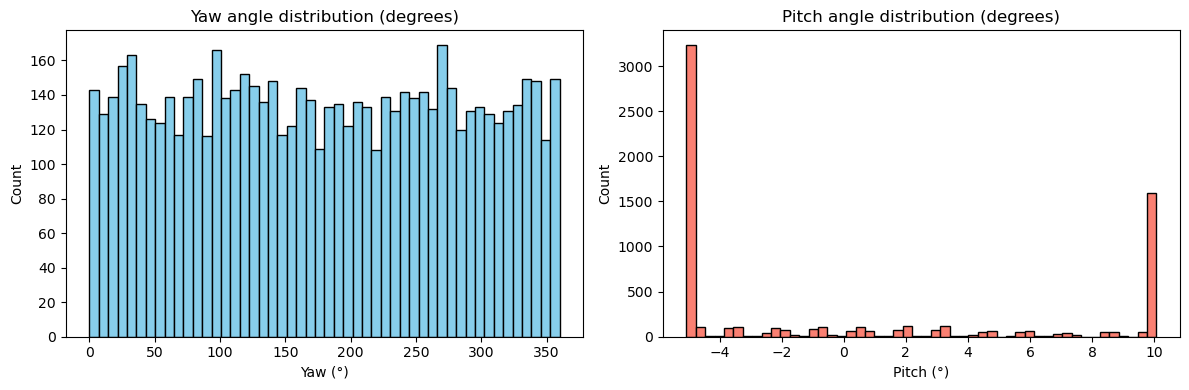

In [36]:
import matplotlib.pyplot as plt

# CSV에서 불러온 라디안 각도 기준
yaw = df['x_angle'].values.astype(np.float32)
pitch = df['y_angle'].values.astype(np.float32)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(yaw, bins=50, color='skyblue', edgecolor='black')
plt.title("Yaw angle distribution (degrees)")
plt.xlabel("Yaw (°)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(pitch, bins=50, color='salmon', edgecolor='black')
plt.title("Pitch angle distribution (degrees)")
plt.xlabel("Pitch (°)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [37]:
print(df[['x_angle', 'y_angle']].head(10))

   x_angle  y_angle
0   334.40    10.00
1    54.72    10.00
2   161.33    -4.12
3    45.33    -5.00
4   267.27     8.29
5   253.36    -5.00
6   120.95     6.50
7   202.71    10.00
8    59.27    10.00
9   306.27    10.00
